#**CNN for detecting pneumonia diseases from medical images**

In [ ]:
# Import necessary libraries
from typing import Final
import glob
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout,LeakyReLU,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet169
from keras.utils import load_img
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
from sklearn.model_selection import train_test_split

##**Data Loading**

In [ ]:
# Mount Google Drive for Google Colab support
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the base directory for chest x-ray, either on Google Colab or localhost
base_dir = "/content/drive/MyDrive/colab_data/data/chest_xray_unified"

In [ ]:
# Execute for both Google Colab and localhost support
os.chdir(base_dir)

In [ ]:
# Define global variables
IMG_HEIGHT = 200
IMG_WIDTH = 200
BATCH = 32
SEED = 42

In [ ]:
# Set the working directory if needed
# os.chdir('/path/to/your/base/directory')

# Find all image file paths for the different datasets (train, test, validation)
train_normal = glob.glob('train/NORMAL/*.jpeg')
train_pneumonia = glob.glob('train/PNEUMONIA/*.jpeg')

test_normal = glob.glob('test/NORMAL/*.jpeg')
test_pneumonia = glob.glob('test/PNEUMONIA/*.jpeg')

val_normal = glob.glob('val/NORMAL/*.jpeg')
val_pneumonia = glob.glob('val/PNEUMONIA/*.jpeg')

# print the number of images found in each category
print("Number of train_normal images:", len(train_normal))
print("Number of train_pneumonia images:", len(train_pneumonia))
print("Number of test_normal images:", len(test_normal))
print("Number of test_pneumonia images:", len(test_pneumonia))
print("Number of val_normal images:", len(val_normal))
print("Number of val_pneumonia images:", len(val_pneumonia))

Number of train_normal images: 1583
Number of train_pneumonia images: 4273
Number of test_normal images: 234
Number of test_pneumonia images: 390
Number of val_normal images: 8
Number of val_pneumonia images: 8


In [ ]:
# Combine all pneumonia images for train, validations, and test sets into one dataset
pneumonia_dataset = [x for x in train_pneumonia]
pneumonia_dataset.extend([x for x in val_pneumonia])
pneumonia_dataset.extend([x for x in test_pneumonia])
# Combine all pneumonia images for train, validations, and test sets into one dataset
normal_dataset = [x for x in train_normal]
normal_dataset.extend([x for x in val_normal])
normal_dataset.extend([x for x in test_normal])
# Create a DataFrame for pneumonia images with a column for class label
pneumonia_df = pd.DataFrame(np.concatenate([['Pneumonia']*len(pneumonia_dataset)]), columns = ['class'])
pneumonia_df['image'] = [x for x in pneumonia_dataset]
# Create a DataFrame for normal images with a column for class label
normal_df = pd.DataFrame(np.concatenate([['Normal']*len(normal_dataset)]), columns = ['class'])
normal_df['image'] = [x for x in normal_dataset]

In [ ]:
pneumonia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4671 entries, 0 to 4670
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   4671 non-null   object
 1   image   4671 non-null   object
dtypes: object(2)
memory usage: 73.1+ KB


In [ ]:
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   1825 non-null   object
 1   image   1825 non-null   object
dtypes: object(2)
memory usage: 28.6+ KB


##**Data Preprocessing**

####**1. Data Splitting and Rebalancing**

In [ ]:
# Split pneumonia DataFame into training and test sets (70% train, 30% test)
df_train_pneumonia, df_test_pneumonia = train_test_split(pneumonia_df, test_size=0.3, random_state=SEED)
# Further split the test set into validation and test sets (50% validation, 50% test)
df_val_pneumonia, df_test_pneumonia = train_test_split(df_test_pneumonia, test_size=0.5, random_state=SEED)
# Split normal DataFame into training and test sets (70% train, 30% test)
df_train_normal, df_test_normal = train_test_split(normal_df, test_size=0.3, random_state=SEED)
# Further split the test set into validation and test sets (50% validation, 50% test)
df_val_normal, df_test_normal = train_test_split(df_test_normal, test_size=0.5, random_state=SEED)
# Concatenate pneumonia and normal training sets into a single DataFrame
df_train = pd.concat([df_train_pneumonia, df_train_normal], ignore_index=True)
# Shuffle the combined Dataframe
df_train = df_train.sample(frac=1, random_state=SEED).reset_index(drop=True)
# Concatenate pneumonia and normal validation sets into a single DataFrame
df_val = pd.concat([df_val_pneumonia, df_val_normal], ignore_index=True)
# Shuffle the combined Dataframe
df_val = df_val.sample(frac=1, random_state=SEED).reset_index(drop=True)
# Concatenate pneumonia and normal test sets into a single DataFrame
df_test = pd.concat([df_test_pneumonia, df_test_normal], ignore_index=True)

####**2. Data Exploration & Visualisation**

<ipython-input-12-d5d09110cbb9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='class', data=df_train, palette="Spectral")


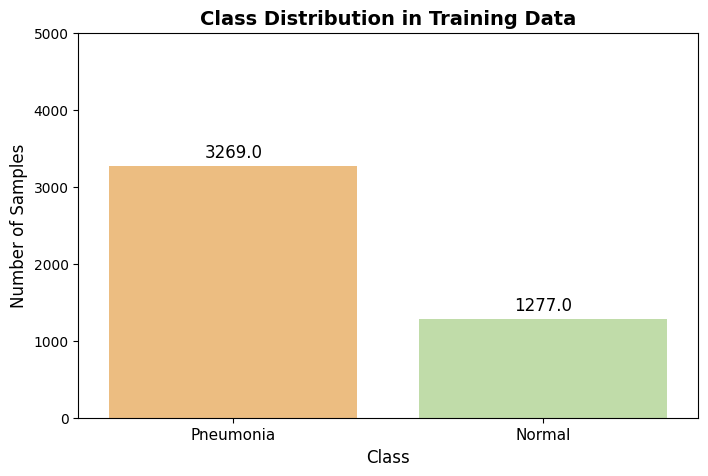

In [ ]:
# Set the size of the plot
plt.figure(figsize=(8, 5))

# Plot the distribution of classes in the training data using count plot
ax = sns.countplot(x='class', data=df_train, palette="Spectral")

# Set the title and labels
plt.title("Class Distribution in Training Data", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.ylim(0, 5000)
plt.xticks([0, 1], ['Pneumonia', 'Normal'], fontsize=11)

# Annotate each bar in the count plot with the counts of each class
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

# Display the plot
plt.show()

<ipython-input-13-8bf179a92ab6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='class', data=df_val, palette="Spectral")


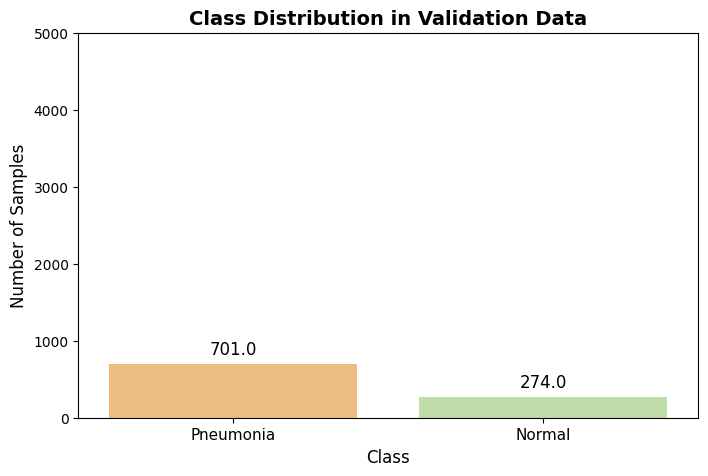

In [ ]:
# Set the size of the plot
plt.figure(figsize=(8, 5))

# Plot the distribution of classes in the validation data using count plot
ax = sns.countplot(x='class', data=df_val, palette="Spectral")

# Set the title and labels
plt.title("Class Distribution in Validation Data", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.ylim(0, 5000)
plt.xticks([0, 1], ['Pneumonia', 'Normal'], fontsize=11)

# Annotate each bar in the count plot with the counts of each class
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

# Display the plot
plt.show()

<ipython-input-14-8bcbbe6efe05>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='class', data=df_test, palette="Spectral")


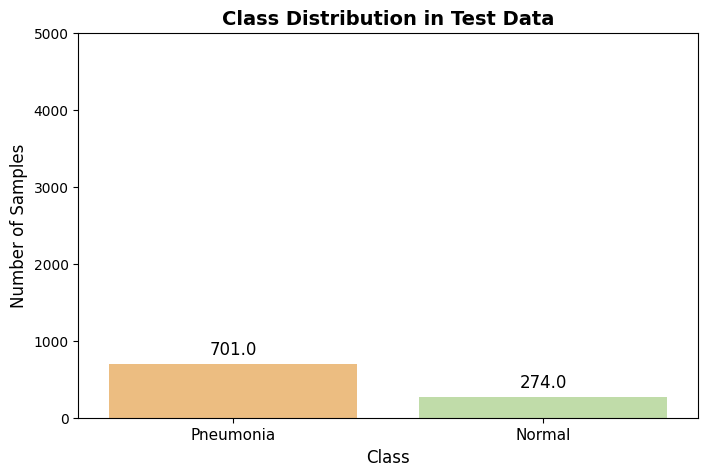

In [ ]:
# Set the size of the plot
plt.figure(figsize=(8, 5))

# Plot the distribution of classes in the test data using count plot
ax = sns.countplot(x='class', data=df_test, palette="Spectral")

# Set the title and labels
plt.title("Class Distribution in Test Data", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.ylim(0, 5000)
plt.xticks([0, 1], ['Pneumonia', 'Normal'], fontsize=11)

# Annotate each bar in the count plot with the counts of each class
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

# Display the plot
plt.show()

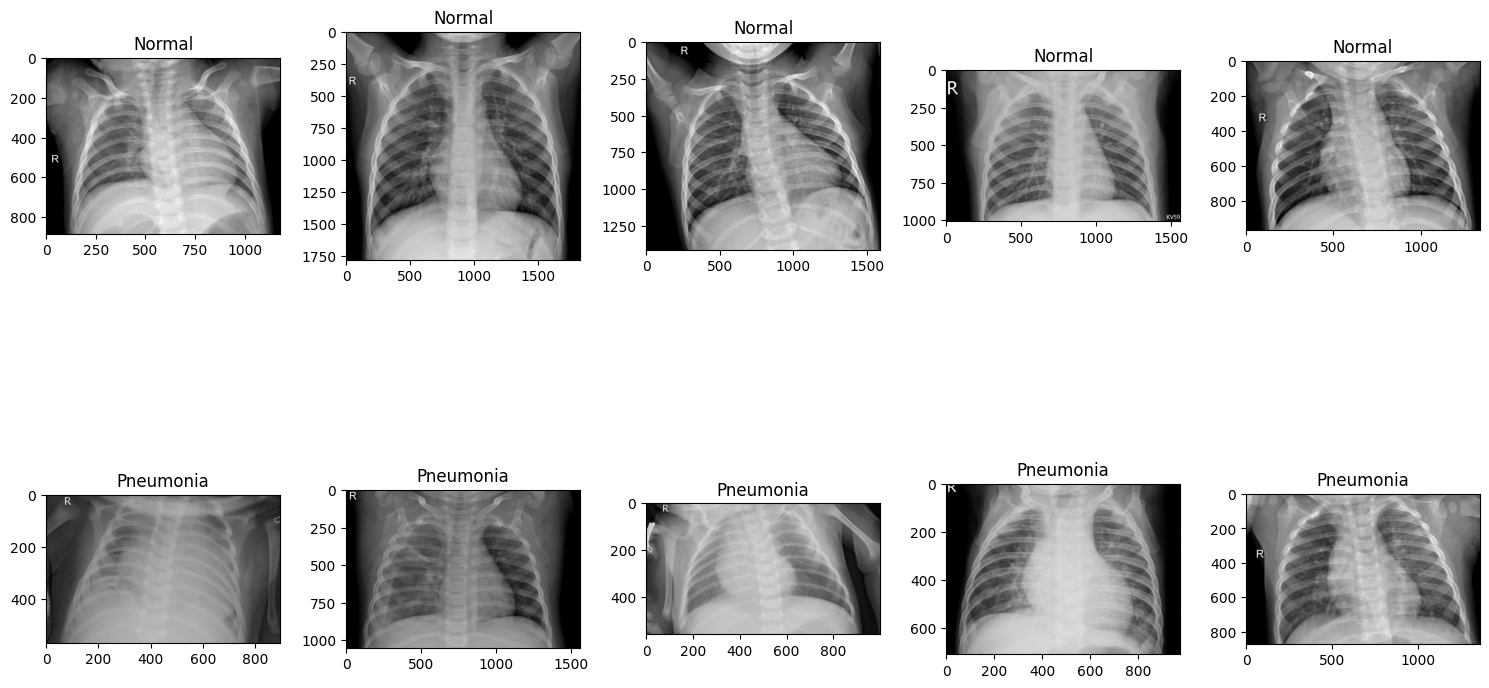

In [ ]:
# Create a figure with two rows and 5 columns of subplots,
# where the first row displays 5 normal x-ray images for pneumonia and
# the second rows displays 5 pneumonia x-ray images
fig, ax = plt.subplots(2, 5, figsize=(15, 10))

# Initialize counters for number of images displayed for each class
normal_count = 0
pneumonia_count = 0

# Loop through the first 50 images in the training DataFrame
for path in df_train['image'][:50]:
    img = load_img(path)

    if 'NORMAL' in path:
        if normal_count < 5:  # Ensure we do not exceed subplot grid
            ax[0][normal_count].imshow(img)
            ax[0][normal_count].set_title('Normal')
            normal_count += 1
    else:
        if pneumonia_count < 5:  # Ensure we do not exceed subplot grid
            ax[1][pneumonia_count].imshow(img)
            ax[1][pneumonia_count].set_title('Pneumonia')
            pneumonia_count += 1

plt.tight_layout()
plt.show()

####**3. Data Augmentation and Normalisation**

In [ ]:
# Define an ImageDataGenerator for the training set data augmentation and normalisation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest') # Normalize pixel values to [0, 1]
# Define an ImageDataGenerator for the validation set with normalisation
val_datagen = ImageDataGenerator(rescale=1./255)
# Define an ImageDataGenerator for the test set with normalisation
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator for the training set using the augmented data generator
# Read image paths and class labels from df_train
train_dataset = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col='image',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED
)
# Create a data generator for the validation set using the rescaling data generator
# Read image paths and class labels from df_val
val_dataset = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=None,
    x_col='image',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED
)
# Create a data generator for the test set using the rescaling data generator
# Read image paths and class labels from df_test
test_dataset = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col='image',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=1,
    shuffle=True,
    seed=SEED
)

Found 4546 validated image filenames belonging to 2 classes.
Found 975 validated image filenames belonging to 2 classes.
Found 975 validated image filenames belonging to 2 classes.


##**Custom CNN Model**

In [ ]:
# Function to build a Convolutiona Neural Network (CNN) model
def build_cnn_model(conv_layers, dense_layers, optimizer='adam'):

    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

    model = Sequential()

    # Add convolutional layers with optional LeakyReLU activation, batch normalisation, dropout and pooling layers
    for i, layer_params in enumerate(conv_layers):
        activation = layer_params['activation']
        padding = 'same'
        if activation == "leaky_relu":
            if i == 0:
                model.add(Conv2D(filters=layer_params['filters'], kernel_size=layer_params['kernel_size'],strides=layer_params['strides'],padding=padding, input_shape=input_shape))
            else:
                model.add(Conv2D(filters=layer_params['filters'],strides=layer_params['strides'], kernel_size=layer_params['kernel_size'],padding=padding,))

            model.add(LeakyReLU(alpha=layer_params['alpha']))
        else:
            if i == 0:
                model.add(Conv2D(filters=layer_params['filters'], kernel_size=layer_params['kernel_size'],
                                activation=layer_params['activation'],strides=layer_params['strides'], input_shape=input_shape,padding=padding,))
            else:
                model.add(Conv2D(filters=layer_params['filters'],strides=layer_params['strides'], kernel_size=layer_params['kernel_size'],
                                activation=layer_params['activation'],padding=padding,))
        model.add(BatchNormalization())

        if 'cnn_dropout' in layer_params:
            model.add(Dropout(rate=layer_params['cnn_dropout']))

        if 'pool_size' in layer_params and 'pool_strides' in layer_params:
            if 'pool_type' in layer_params and layer_params['pool_type'] == 'average':
              model.add(AveragePooling2D(pool_size=layer_params['pool_size'], strides=layer_params['pool_strides']))
            else:
                model.add(MaxPooling2D(pool_size=layer_params['pool_size'], strides=layer_params['pool_strides']))

    model.add(Flatten())

    # Add dense layer with optional dropout
    for layer_params in dense_layers:
        model.add(Dense(units=layer_params['units'], activation=layer_params['activation']))
        if 'dropout' in layer_params:
            model.add(Dropout(rate=layer_params['dropout']))


    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

    return model

In [ ]:
# Define callbacks for model training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
earning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# Function to fit the CNN Model
def fit_cnn_model(datasets,model,epochs=10):
    train_dataset, val_dataset = datasets
    fit_results = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose = 0,
    callbacks=[checkpoint, early_stopping, learning_rate_reduction])
    return fit_results


In [ ]:
# Function to plot the training and validation loss over epochs
def plot_history(fit_results):
  # Store history in pandas dataframe
  history_df = pd.DataFrame(fit_results.history)
  display(history_df)

  print()
  print('___________________________________________________________________________________')
  # Plot the training and validation loss
  plt.plot(fit_results.history['val_loss'], 'green')
  plt.plot(fit_results.history['loss'], 'blue')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Validation Loss', 'Training Loss'], loc= 'best')
  plt.show()

  print()
  print('___________________________________________________________________________________')

In [ ]:
# Function to evaluate the model on test data
def evaluate_cnn_model(test_dataset,model):
  print('Evaluate model on test data:')
  test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
  print('Test Accuracy:',  test_acc)
  print('Test Loss:',  test_loss)

####**Test Set 1**
* One convolutional layer (32 filters)
* One dense layer (32 filters)
* No dropouts

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 200, 200, 32)      128       
 chNormalization)                                                
                                                                 
 flatten_5 (Flatten)         (None, 1280000)           0         
                                                                 
 dense_10 (Dense)            (None, 32)                40960032  
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 40961089 (156.25 MB)
Trainable params: 40961025 (156.25 MB)
Non-trainable params: 64 (256.00 Byte)
_______

,loss,accuracy,val_loss,val_accuracy,lr
0,1.315726,0.701496,0.691195,0.718974,0.000100
1,0.674148,0.732732,0.635422,0.841026,0.000100
2,0.397162,0.813242,0.506878,0.739487,0.000100
3,0.346812,0.840959,0.308290,0.885128,0.000100
4,0.317312,0.863176,0.254910,0.897436,0.000100
5,0.314413,0.865596,0.300047,0.870769,0.000100
6,0.299837,0.870656,0.247086,0.893333,0.000100
7,0.287812,0.876815,0.247642,0.887179,0.000030
8,0.275325,0.879674,0.282420,0.869744,0.000030
9,0.265066,0.885614,0.264462,0.881026,0.000009



___________________________________________________________________________________


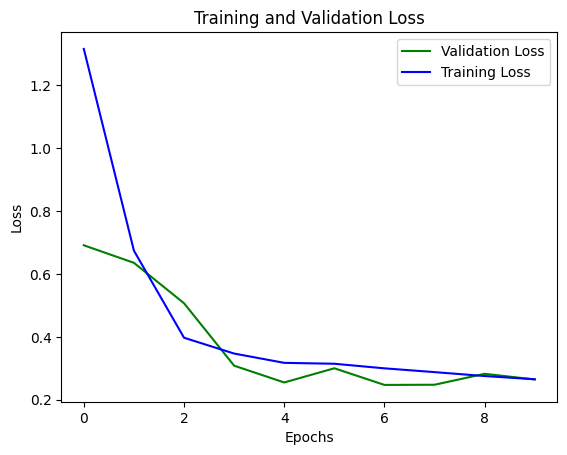


___________________________________________________________________________________


In [ ]:
#Test Set 1
#One convolutional layer, one dense layer, no dropouts.
conv_layers = [
    {'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu','strides':(1,1)},
]

dense_layers = [
    {'units': 32, 'activation': 'relu',}
]
adam_optimizer = Adam(learning_rate=0.0001)
model = build_cnn_model(conv_layers, dense_layers,adam_optimizer)
model.summary()
datasets = (train_dataset,val_dataset)
fit_results_1 = fit_cnn_model(datasets,model,epochs=10)
evaluate_cnn_model(test_dataset,model)
plot_history(fit_results_1)

####**Test Set 2 (Crashes)**
*   One convolutional layer (128 filters)
*   One dense layer (128 filters)
*   No dropouts


In [ ]:
#Test Set 2
#One convolutional layer 128 filters, one dense layer 128 filters, no dropouts.
#Crash - Ram Exceed
conv_layers = [
    {'filters': 128, 'kernel_size': (3, 3), 'activation': 'relu','strides':(1,1)},
]

dense_layers = [
    {'units': 128, 'activation': 'relu',}
]
adam_optimizer = Adam(learning_rate=0.0001)
model = build_cnn_model(conv_layers, dense_layers,adam_optimizer)
model.summary()
datasets = (train_dataset,val_dataset)
fit_results_2 = fit_cnn_model(datasets,model,epochs=10)
evaluate_cnn_model(test_dataset,model)
plot_history(fit_results_2)

####**Test Set 3**
*   One convolutional layer (128 filters)
*   One average pooling layer
*   One dense layer (128 filters)
*   No dropouts

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 128)     3584      
                                                                 
 batch_normalization_6 (Bat  (None, 200, 200, 128)     512       
 chNormalization)                                                
                                                                 
 average_pooling2d_2 (Avera  (None, 66, 66, 128)       0         
 gePooling2D)                                                    
                                                                 
 flatten_6 (Flatten)         (None, 557568)            0         
                                                                 
 dense_12 (Dense)            (None, 128)               71368832  
                                                                 
 dense_13 (Dense)            (None, 1)                

,loss,accuracy,val_loss,val_accuracy,lr
0,0.909454,0.757369,0.594422,0.841026,0.000100
1,0.331830,0.855037,0.513731,0.720000,0.000100
2,0.321980,0.856797,0.408567,0.734359,0.000100
3,0.263633,0.889793,0.296332,0.915897,0.000030
4,0.259071,0.896612,0.217518,0.921026,0.000030
5,0.261458,0.890893,0.413069,0.791795,0.000030
6,0.255816,0.897272,0.210576,0.921026,0.000030
7,0.245484,0.902992,0.223936,0.904615,0.000009
8,0.240018,0.905631,0.286837,0.867692,0.000009
9,0.240291,0.904971,0.273131,0.871795,0.000003



___________________________________________________________________________________


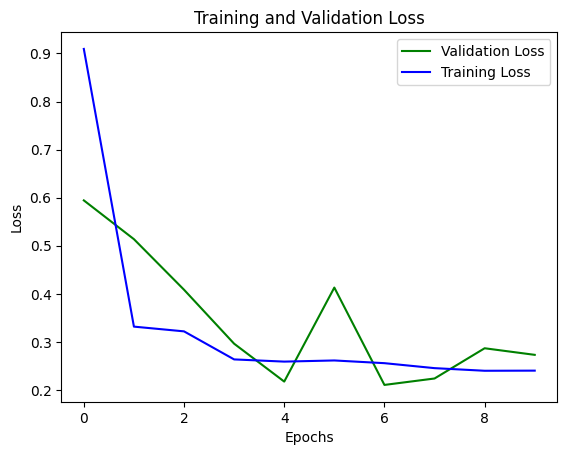


___________________________________________________________________________________


In [ ]:
#Test Set 3
#One convolutional layer 128 filters, one average pooling layer, one dense layer 128 filters, no dropouts.
conv_layers = [
    {'filters': 128, 'kernel_size': (3, 3), 'activation': 'relu','strides':(1,1),'pool_type':'average','pool_size':(3,3),'pool_strides':(3,3)},
]

dense_layers = [
    {'units': 128, 'activation': 'relu',}
]
adam_optimizer = Adam(learning_rate=0.0001)
model = build_cnn_model(conv_layers, dense_layers,adam_optimizer)
model.summary()
datasets = (train_dataset,val_dataset)
fit_results_2 = fit_cnn_model(datasets,model,epochs=10)
evaluate_cnn_model(test_dataset,model)
plot_history(fit_results_2)

####**Test Set 4**
*   One convolutional layer (128 filters)
*   One average pooling layer
*   One dense layer (128 filters)
*   Dropouts

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 200, 200, 128)     3584      
                                                                 
 batch_normalization_7 (Bat  (None, 200, 200, 128)     512       
 chNormalization)                                                
                                                                 
 average_pooling2d_3 (Avera  (None, 66, 66, 128)       0         
 gePooling2D)                                                    
                                                                 
 flatten_7 (Flatten)         (None, 557568)            0         
                                                                 
 dense_14 (Dense)            (None, 128)               71368832  
                                                                 
 dropout_1 (Dropout)         (None, 128)              

,loss,accuracy,val_loss,val_accuracy,lr
0,0.910650,0.768588,0.613223,0.807180,0.00010
1,0.327362,0.861197,0.464056,0.774359,0.00010
2,0.302684,0.871315,0.454448,0.876923,0.00010
3,0.289028,0.874615,0.292380,0.911795,0.00010
4,0.268712,0.887374,0.276302,0.889231,0.00010
5,0.270874,0.885834,0.337934,0.835897,0.00010
6,0.257791,0.897712,0.212692,0.920000,0.00003
7,0.249876,0.898592,0.208826,0.926154,0.00003
8,0.254751,0.898812,0.408958,0.795897,0.00003
9,0.242575,0.906071,0.310562,0.855385,0.00003



___________________________________________________________________________________


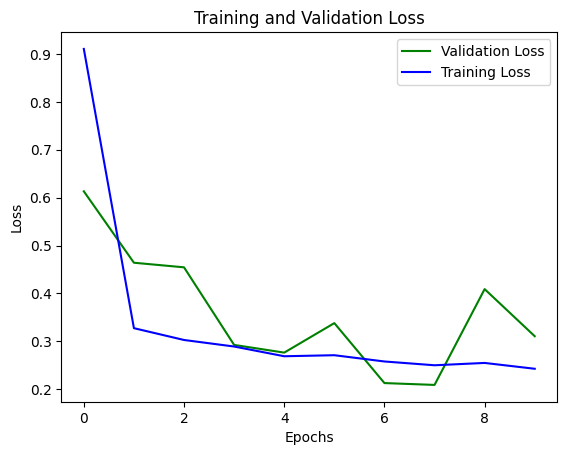


___________________________________________________________________________________


In [ ]:
#Test Set 4
#One convolutional layer 128 filters, one average pooling layer, one dense layer 128 filters, and dropouts.
conv_layers = [
    {'filters': 128, 'kernel_size': (3, 3), 'activation': 'relu','strides':(1,1),'pool_type':'average','pool_size':(3,3),'pool_strides':(3,3)},
]

dense_layers = [
    {'units': 128, 'activation': 'relu','dropout':0.15}
]
adam_optimizer = Adam(learning_rate=0.0001)
model = build_cnn_model(conv_layers, dense_layers,adam_optimizer)
model.summary()
datasets = (train_dataset,val_dataset)
fit_results_3 = fit_cnn_model(datasets,model,epochs=10)
evaluate_cnn_model(test_dataset,model)
plot_history(fit_results_3)

####**Test Set 5**
* Two convolutional layers (128/32 filters)
* One average pooling layer
* One dense layer (128 filters)
* Dropouts

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 200, 200, 128)     3584      
                                                                 
 batch_normalization_8 (Bat  (None, 200, 200, 128)     512       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 200, 200, 32)      36896     
                                                                 
 batch_normalization_9 (Bat  (None, 200, 200, 32)      128       
 chNormalization)                                                
                                                                 
 average_pooling2d_4 (Avera  (None, 66, 66, 32)        0         
 gePooling2D)                                                    
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 96s 670ms/step - loss: 0.2680 - accuracy: 0.8905 - val_loss: 0.1873 - val_accuracy: 0.9436 - lr: 3.0000e-05
Epoch 6/10
143/143 [==============================] - 91s 632ms/step - loss: 0.2635 - accuracy: 0.8966 - val_loss: 0.2120 - val_accuracy: 0.9108 - lr: 3.0000e-05
Epoch 7/10
143/143 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.8902
Epoch 7: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
143/143 [==============================] - 91s 638ms/step - loss: 0.2595 - accuracy: 0.8902 - val_loss: 0.1809 - val_accuracy: 0.9436 - lr: 3.0000e-05
Epoch 8/10
143/143 [==============================] - 91s 634ms/step - loss: 0.2396 - accuracy: 0.9070 - val_loss: 0.2342 - val_accuracy: 0.9108 - lr: 9.0000e-06
Epoch 9/10
143/143 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.9050
Epoch 9: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
143/143 [====================

,loss,accuracy,val_loss,val_accuracy,lr
0,0.643384,0.768808,0.967620,0.718974,0.000100
1,0.361612,0.849758,1.286963,0.718974,0.000100
2,0.327455,0.857017,1.372020,0.718974,0.000100
3,0.276226,0.884734,0.321744,0.857436,0.000030
4,0.267967,0.890453,0.187322,0.943590,0.000030
5,0.263522,0.896612,0.211961,0.910769,0.000030
6,0.259493,0.890233,0.180858,0.943590,0.000030
7,0.239638,0.906951,0.234203,0.910769,0.000009
8,0.237992,0.904971,0.207101,0.924103,0.000009
9,0.226377,0.910691,0.186543,0.934359,0.000003



___________________________________________________________________________________


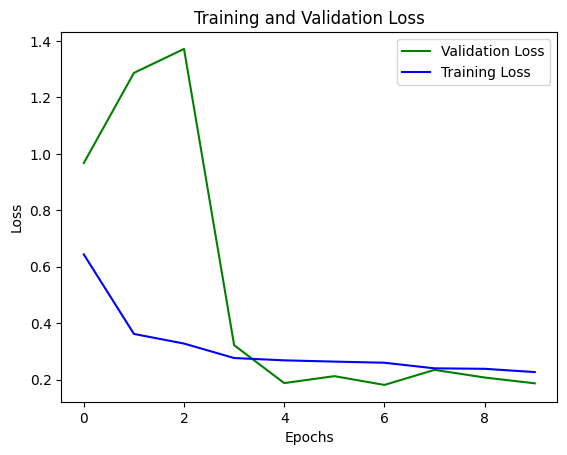


___________________________________________________________________________________


In [ ]:
#Test Set 5
#Two convolutional layers 128/32 filters, one average pooling layer, one dense layer 128 filters, and dropouts.
conv_layers = [
    {'filters': 128, 'kernel_size': (3, 3), 'activation': 'relu','strides':(1,1)},
    {'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu','strides':(1,1),'pool_type':'average','pool_size':(3,3),'pool_strides':(3,3)},
]

dense_layers = [
    {'units': 128, 'activation': 'relu','dropout':0.15}
]
adam_optimizer = Adam(learning_rate=0.0001)
model = build_cnn_model(conv_layers, dense_layers,adam_optimizer)
model.summary()
datasets = (train_dataset,val_dataset)
fit_results_4 = fit_cnn_model(datasets,model,epochs=10)
evaluate_cnn_model(test_dataset,model)
plot_history(fit_results_4)

##**Pretrained CNN Model: DenseNet-169**

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


146/146 [==============================] - 112s 709ms/step - loss: 0.8372 - binary_accuracy: 0.6668 - val_loss: 0.5359 - val_binary_accuracy: 0.7431 - lr: 1.0000e-05
Epoch 2/30
146/146 [==============================] - ETA: 0s - loss: 0.5737 - binary_accuracy: 0.7521

146/146 [==============================] - 98s 668ms/step - loss: 0.5737 - binary_accuracy: 0.7521 - val_loss: 0.3868 - val_binary_accuracy: 0.8281 - lr: 1.0000e-05
Epoch 3/30
146/146 [==============================] - ETA: 0s - loss: 0.4526 - binary_accuracy: 0.8022

146/146 [==============================] - 98s 671ms/step - loss: 0.4526 - binary_accuracy: 0.8022 - val_loss: 0.3290 - val_binary_accuracy: 0.8542 - lr: 1.0000e-05
Epoch 4/30
146/146 [==============================] - ETA: 0s - loss: 0.3917 - binary_accuracy: 0.8308

146/146 [==============================] - 98s 670ms/step - loss: 0.3917 - binary_accuracy: 0.8308 - val_loss: 0.2940 - val_binary_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 5/30
146/146 [==============================] - ETA: 0s - loss: 0.3551 - binary_accuracy: 0.8420

146/146 [==============================] - 99s 680ms/step - loss: 0.3551 - binary_accuracy: 0.8420 - val_loss: 0.2796 - val_binary_accuracy: 0.8802 - lr: 1.0000e-05
Epoch 6/30
146/146 [==============================] - ETA: 0s - loss: 0.3253 - binary_accuracy: 0.8676

146/146 [==============================] - 98s 670ms/step - loss: 0.3253 - binary_accuracy: 0.8676 - val_loss: 0.2750 - val_binary_accuracy: 0.8802 - lr: 1.0000e-05
Epoch 7/30
146/146 [==============================] - ETA: 0s - loss: 0.3134 - binary_accuracy: 0.8687

146/146 [==============================] - 98s 668ms/step - loss: 0.3134 - binary_accuracy: 0.8687 - val_loss: 0.2480 - val_binary_accuracy: 0.9028 - lr: 1.0000e-05
Epoch 8/30
146/146 [==============================] - ETA: 0s - loss: 0.3026 - binary_accuracy: 0.8691

146/146 [==============================] - 96s 660ms/step - loss: 0.3026 - binary_accuracy: 0.8691 - val_loss: 0.2541 - val_binary_accuracy: 0.8976 - lr: 1.0000e-05
Epoch 9/30
146/146 [==============================] - ETA: 0s - loss: 0.2685 - binary_accuracy: 0.8940

146/146 [==============================] - 99s 675ms/step - loss: 0.2685 - binary_accuracy: 0.8940 - val_loss: 0.2400 - val_binary_accuracy: 0.9010 - lr: 1.0000e-05
Epoch 10/30
146/146 [==============================] - ETA: 0s - loss: 0.2689 - binary_accuracy: 0.8805

146/146 [==============================] - 95s 652ms/step - loss: 0.2689 - binary_accuracy: 0.8805 - val_loss: 0.2699 - val_binary_accuracy: 0.8819 - lr: 1.0000e-05
Epoch 11/30
146/146 [==============================] - ETA: 0s - loss: 0.2579 - binary_accuracy: 0.8917

146/146 [==============================] - 96s 655ms/step - loss: 0.2579 - binary_accuracy: 0.8917 - val_loss: 0.2502 - val_binary_accuracy: 0.8941 - lr: 1.0000e-05
Epoch 12/30
146/146 [==============================] - ETA: 0s - loss: 0.2500 - binary_accuracy: 0.9000

146/146 [==============================] - 95s 652ms/step - loss: 0.2500 - binary_accuracy: 0.9000 - val_loss: 0.2578 - val_binary_accuracy: 0.8854 - lr: 1.0000e-05
Epoch 13/30
146/146 [==============================] - ETA: 0s - loss: 0.2539 - binary_accuracy: 0.8960

146/146 [==============================] - 96s 656ms/step - loss: 0.2539 - binary_accuracy: 0.8960 - val_loss: 0.2466 - val_binary_accuracy: 0.8924 - lr: 1.0000e-05
Epoch 14/30
146/146 [==============================] - ETA: 0s - loss: 0.2407 - binary_accuracy: 0.8988

146/146 [==============================] - 99s 677ms/step - loss: 0.2407 - binary_accuracy: 0.8988 - val_loss: 0.2334 - val_binary_accuracy: 0.9045 - lr: 1.0000e-05
Epoch 15/30
146/146 [==============================] - ETA: 0s - loss: 0.2409 - binary_accuracy: 0.9005

146/146 [==============================] - 96s 656ms/step - loss: 0.2409 - binary_accuracy: 0.9005 - val_loss: 0.2404 - val_binary_accuracy: 0.9045 - lr: 1.0000e-05
Epoch 16/30
146/146 [==============================] - ETA: 0s - loss: 0.2322 - binary_accuracy: 0.9099

146/146 [==============================] - 96s 657ms/step - loss: 0.2322 - binary_accuracy: 0.9099 - val_loss: 0.2419 - val_binary_accuracy: 0.9045 - lr: 1.0000e-05
Epoch 17/30
146/146 [==============================] - ETA: 0s - loss: 0.2346 - binary_accuracy: 0.9046

146/146 [==============================] - 98s 671ms/step - loss: 0.2346 - binary_accuracy: 0.9046 - val_loss: 0.2229 - val_binary_accuracy: 0.9132 - lr: 1.0000e-05
Epoch 18/30
146/146 [==============================] - ETA: 0s - loss: 0.2266 - binary_accuracy: 0.9119

146/146 [==============================] - 98s 670ms/step - loss: 0.2266 - binary_accuracy: 0.9119 - val_loss: 0.2181 - val_binary_accuracy: 0.9132 - lr: 1.0000e-05
Epoch 19/30
146/146 [==============================] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9074

146/146 [==============================] - 97s 665ms/step - loss: 0.2314 - binary_accuracy: 0.9074 - val_loss: 0.2305 - val_binary_accuracy: 0.9080 - lr: 1.0000e-05
Epoch 20/30
146/146 [==============================] - ETA: 0s - loss: 0.2113 - binary_accuracy: 0.9166

146/146 [==============================] - 98s 668ms/step - loss: 0.2113 - binary_accuracy: 0.9166 - val_loss: 0.2151 - val_binary_accuracy: 0.9167 - lr: 1.0000e-05
Epoch 21/30
146/146 [==============================] - ETA: 0s - loss: 0.2213 - binary_accuracy: 0.9134

146/146 [==============================] - 96s 656ms/step - loss: 0.2213 - binary_accuracy: 0.9134 - val_loss: 0.2237 - val_binary_accuracy: 0.9149 - lr: 1.0000e-05
Epoch 22/30
146/146 [==============================] - ETA: 0s - loss: 0.2246 - binary_accuracy: 0.9082

146/146 [==============================] - 95s 651ms/step - loss: 0.2246 - binary_accuracy: 0.9082 - val_loss: 0.2271 - val_binary_accuracy: 0.9132 - lr: 1.0000e-05
Epoch 23/30
146/146 [==============================] - ETA: 0s - loss: 0.2072 - binary_accuracy: 0.9151

146/146 [==============================] - 98s 668ms/step - loss: 0.2072 - binary_accuracy: 0.9151 - val_loss: 0.2035 - val_binary_accuracy: 0.9167 - lr: 1.0000e-05
Epoch 24/30
146/146 [==============================] - ETA: 0s - loss: 0.2142 - binary_accuracy: 0.9125

146/146 [==============================] - 97s 664ms/step - loss: 0.2142 - binary_accuracy: 0.9125 - val_loss: 0.2133 - val_binary_accuracy: 0.9167 - lr: 1.0000e-05
Epoch 25/30
146/146 [==============================] - ETA: 0s - loss: 0.2064 - binary_accuracy: 0.9177

146/146 [==============================] - 97s 667ms/step - loss: 0.2064 - binary_accuracy: 0.9177 - val_loss: 0.1932 - val_binary_accuracy: 0.9323 - lr: 1.0000e-05
Epoch 26/30
146/146 [==============================] - ETA: 0s - loss: 0.2152 - binary_accuracy: 0.9168

146/146 [==============================] - 96s 657ms/step - loss: 0.2152 - binary_accuracy: 0.9168 - val_loss: 0.2279 - val_binary_accuracy: 0.9062 - lr: 1.0000e-05
Epoch 27/30
146/146 [==============================] - ETA: 0s - loss: 0.2016 - binary_accuracy: 0.9209

146/146 [==============================] - 96s 657ms/step - loss: 0.2016 - binary_accuracy: 0.9209 - val_loss: 0.2016 - val_binary_accuracy: 0.9253 - lr: 1.0000e-05
Epoch 28/30
146/146 [==============================] - ETA: 0s - loss: 0.1965 - binary_accuracy: 0.9269

146/146 [==============================] - 96s 660ms/step - loss: 0.1965 - binary_accuracy: 0.9269 - val_loss: 0.2030 - val_binary_accuracy: 0.9219 - lr: 1.0000e-05
Epoch 29/30
146/146 [==============================] - ETA: 0s - loss: 0.2035 - binary_accuracy: 0.9245

146/146 [==============================] - 96s 654ms/step - loss: 0.2035 - binary_accuracy: 0.9245 - val_loss: 0.2029 - val_binary_accuracy: 0.9219 - lr: 1.0000e-05
Epoch 30/30
146/146 [==============================] - ETA: 0s - loss: 0.1971 - binary_accuracy: 0.9213

146/146 [==============================] - 97s 662ms/step - loss: 0.1971 - binary_accuracy: 0.9213 - val_loss: 0.1959 - val_binary_accuracy: 0.9306 - lr: 1.0000e-05
Evaluate model on test data:
Test Accuracy: 0.9028961062431335
Test Loss: 0.23814699053764343


,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,0.837158,0.666810,0.535922,0.743056,0.00001
1,0.573715,0.752150,0.386844,0.828125,0.00001
2,0.452570,0.802236,0.328969,0.854167,0.00001
3,0.391745,0.830825,0.294039,0.875000,0.00001
4,0.355123,0.842003,0.279602,0.880208,0.00001
5,0.325277,0.867584,0.274954,0.880208,0.00001
6,0.313390,0.868659,0.248049,0.902778,0.00001
7,0.302630,0.869089,0.254096,0.897569,0.00001
8,0.268512,0.894024,0.240043,0.901042,0.00001
9,0.268944,0.880482,0.269931,0.881944,0.00001



___________________________________________________________________________________


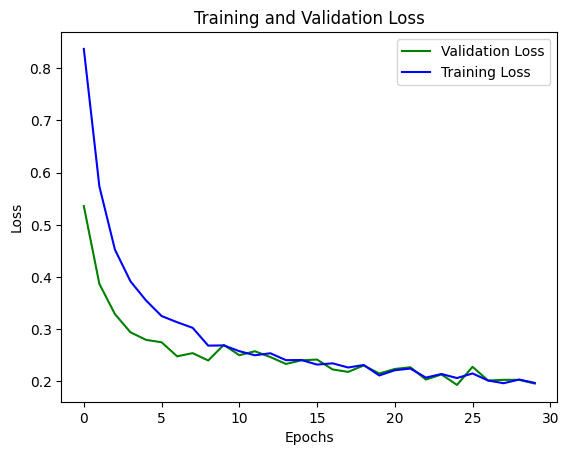


___________________________________________________________________________________


In [ ]:
# Load the pre-trained DenseNet121 model
base_model = DenseNet169(
    weights='imagenet',
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    pooling = 'max'
    )

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.15)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the complete model
densenet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
densenet_model.compile(
      optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
      loss = 'binary_crossentropy',
      metrics='binary_accuracy')

densenet_model.summary()
dnet_history = fit_cnn_model(densenet_model)
evaluate_cnn_model(densenet_model)
plot_history(dnet_history)